In [1]:
!nvidia-smi

Sat Feb 22 12:42:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 6000                On  |   00000000:AF:00.0 Off |                  Off |
| 33%   28C    P8              4W /  260W |       1MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /storage/scratch1/2/dkhattak6


In [3]:
import torch
import torch._C

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.utils.cpp_extension import CUDA_HOME

print(CUDA_HOME)

/usr/local/cuda


In [5]:
print(torch._C)

<module 'torch._C' from '/storage/scratch1/2/dkhattak6/.venv/lib/python3.12/site-packages/torch/_C.cpython-312-x86_64-linux-gnu.so'>


In [7]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/storage/scratch1/2/dkhattak6/weights/sam_vit_h_4b8939.pth ; exist: True


In [8]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(
    HOME, "weights", "groundingdino_swint_ogc.pth"
)
print(
    GROUNDING_DINO_CHECKPOINT_PATH,
    "; exist:",
    os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH),
)

/storage/scratch1/2/dkhattak6/weights/groundingdino_swint_ogc.pth ; exist: True


In [9]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(
    HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
)
print(
    GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH)
)

/storage/scratch1/2/dkhattak6/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [5]:
print(torch.version.cuda)

11.8


In [6]:
print(DEVICE)

cuda


In [10]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
)

/storage/scratch1/2/dkhattak6/GroundingDINO


/storage/scratch1/2/dkhattak6/.venv/lib/python3.12/site-packages/timm-1.0.14-py3.12.egg/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/storage/scratch1/2/dkhattak6/.venv/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [ ]:
from segment_anything import sam_model_registry, SamPredictor

SAM_ENCODER_VERSION = "vit_h"


sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(
    device=DEVICE
)
sam_predictor = SamPredictor(sam)

In [12]:
SOURCE_IMAGE_PATH = f"{HOME}/data/CBN-can-A1-20230705.jpg"
CLASSES = [
    "leaf",
    "flower",
    "sand",
    "wood",
    "stone",
    "tape",
    "plant",
    "tree",
    "rock",
    "vegetation",
]
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.1

In [13]:
from typing import List


def enhance_class_name(class_names: List[str]) -> List[str]:
    return [f"all {class_name}s" for class_name in class_names]

/storage/scratch1/2/dkhattak6/.venv/lib/python3.12/site-packages/transformers-4.48.3-py3.12.egg/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/storage/scratch1/2/dkhattak6/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/storage/scratch1/2/dkhattak6/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


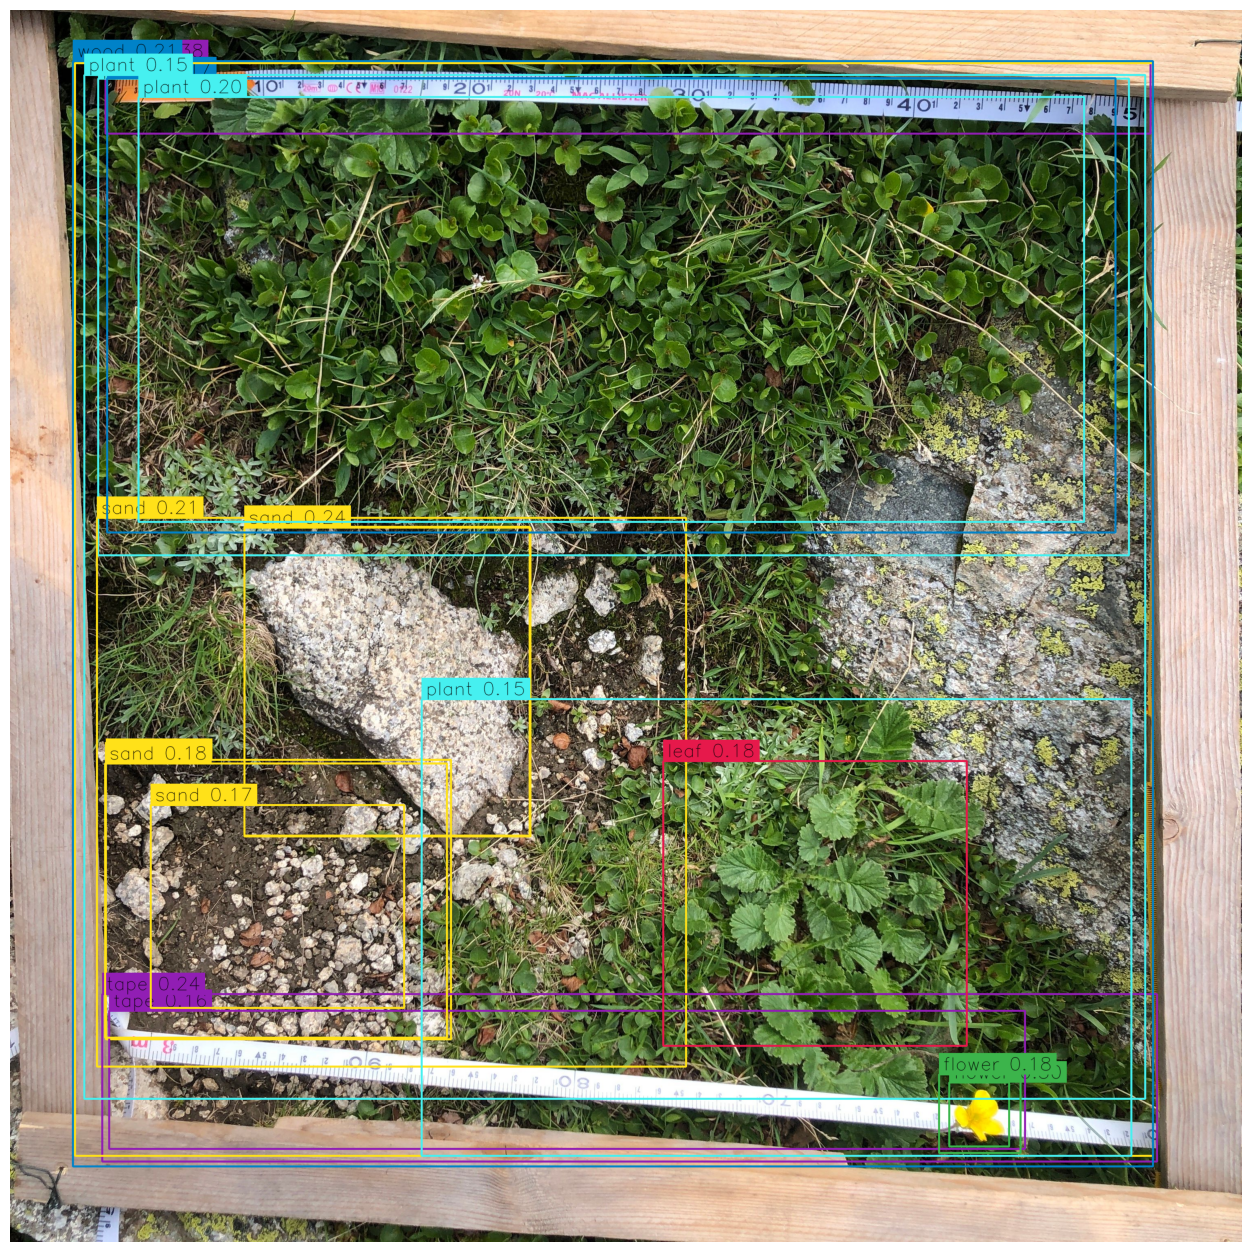

In [14]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
)
# print(detections)
# annotate image with detections
box_annotator = sv.BoxAnnotator(
    thickness=3,  # Adjust line thickness
    text_scale=1.5,  # Adjust text size
)
# print(detections)
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]
annotated_frame = box_annotator.annotate(
    scene=image.copy(), detections=detections, labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [15]:
import numpy as np
from segment_anything import SamPredictor


def segment(
    sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray
) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(box=box, multimask_output=True)
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

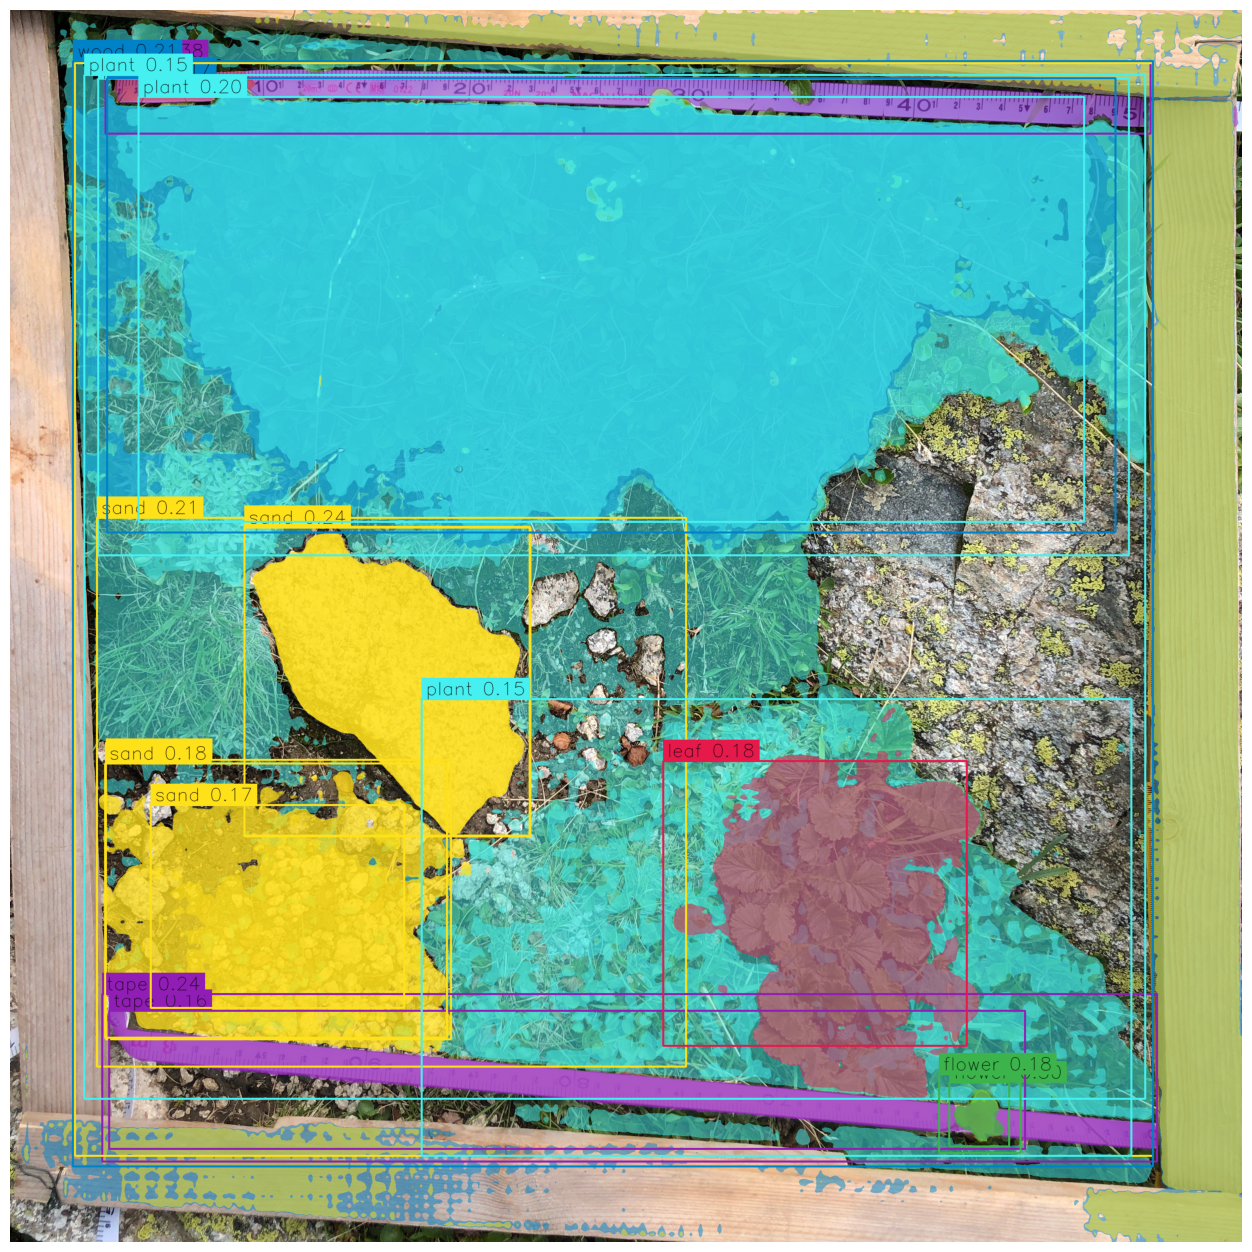

In [16]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy,
)

# annotate image with detections
box_annotator = sv.BoxAnnotator(
    thickness=3,  # Adjust line thickness
    text_scale=1.5,  # Adjust text size
)
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels
)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

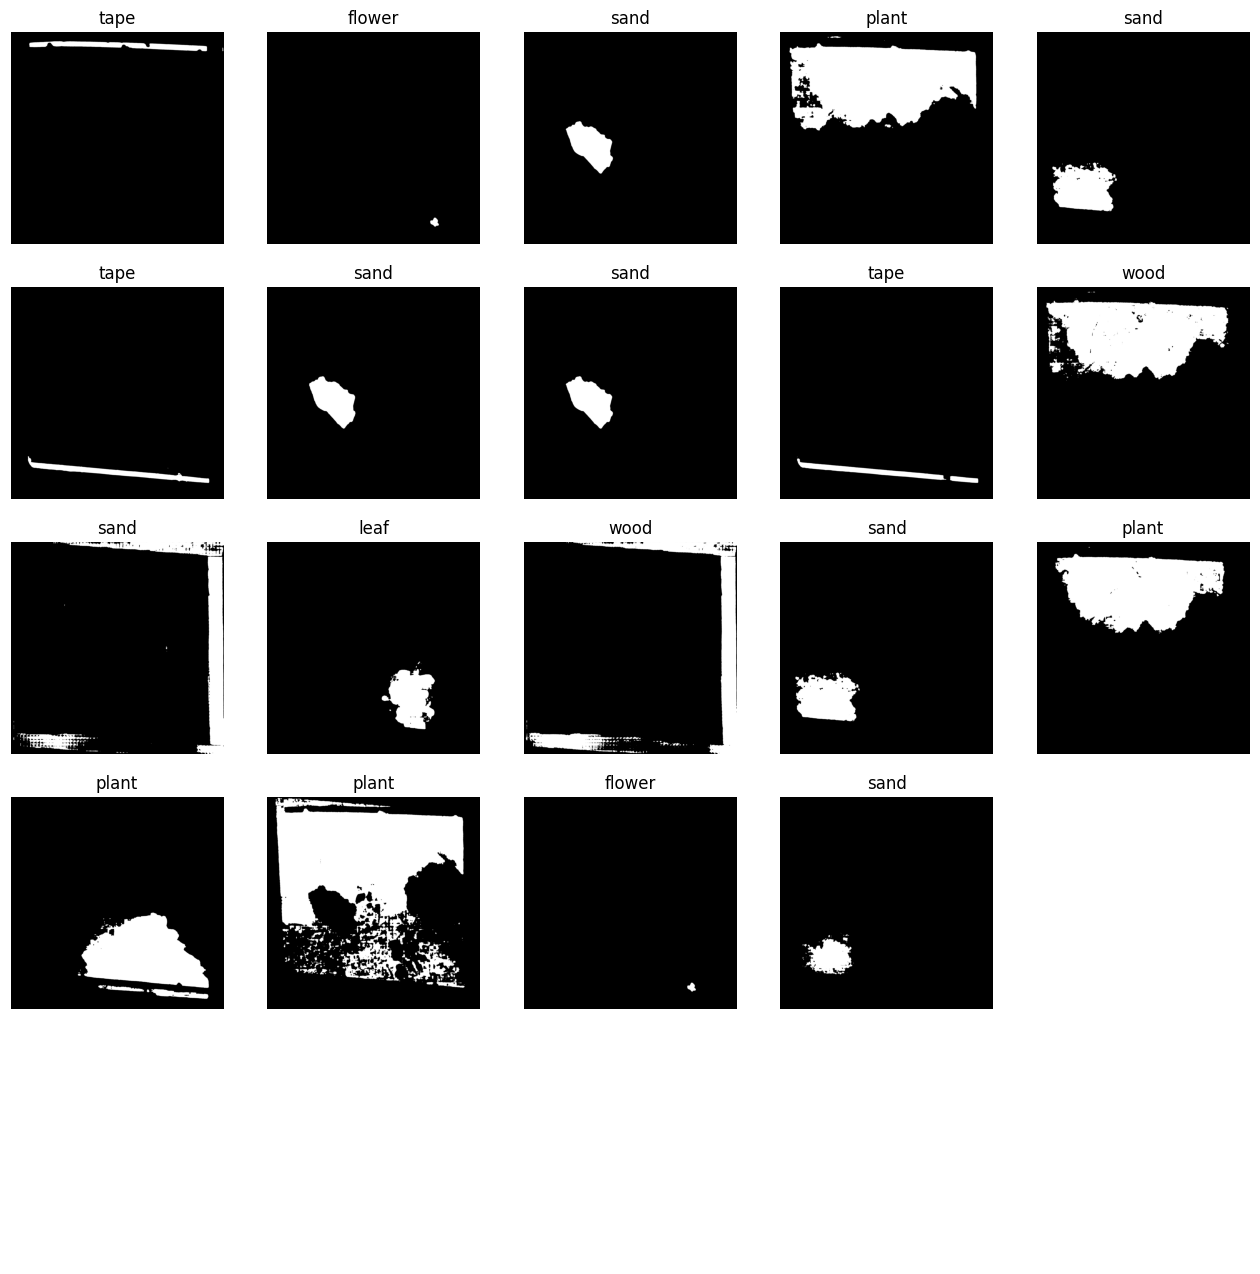

In [17]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [CLASSES[class_id] for class_id in detections.class_id]

sv.plot_images_grid(
    images=detections.mask,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16),
)

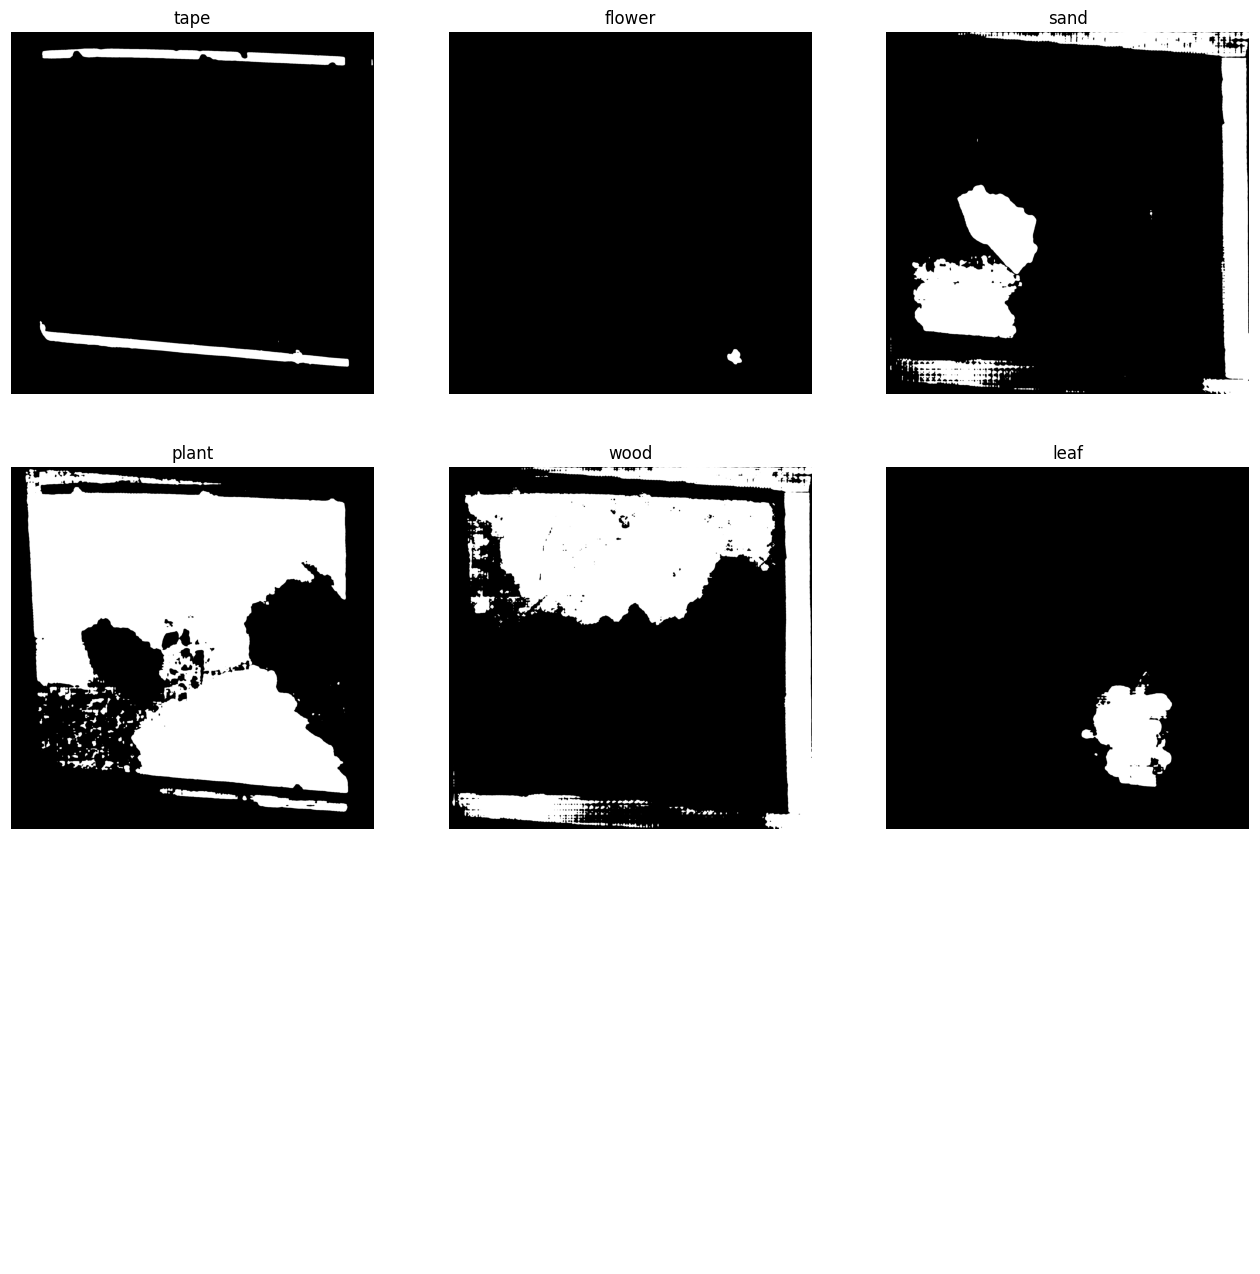

In [ ]:
merged_masks = []
merged_titles = []

grouped = {}  # {class_id: [mask1, mask2, ...]}
for mask, class_id in zip(detections.mask, detections.class_id):
    if class_id not in grouped:
        grouped[class_id] = []
    grouped[class_id].append(mask)


for class_id, masks in grouped.items():
    merged_mask = np.any(
        np.stack(masks, axis=0), axis=0
    )  # Basically doing a Logical OR over the masks
    merged_masks.append(merged_mask)
    merged_titles.append(CLASSES[class_id])

grid_size_dimension = math.ceil(math.sqrt(len(merged_masks)))

sv.plot_images_grid(
    images=merged_masks,
    titles=merged_titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16),
)

In [28]:
segmented_images = []
for mask in merged_masks:
    mask_uint8 = (mask.astype(np.uint8)) * 255
    segmented_image = cv2.bitwise_and(image, image, mask=mask_uint8)
    segmented_images.append(segmented_image)

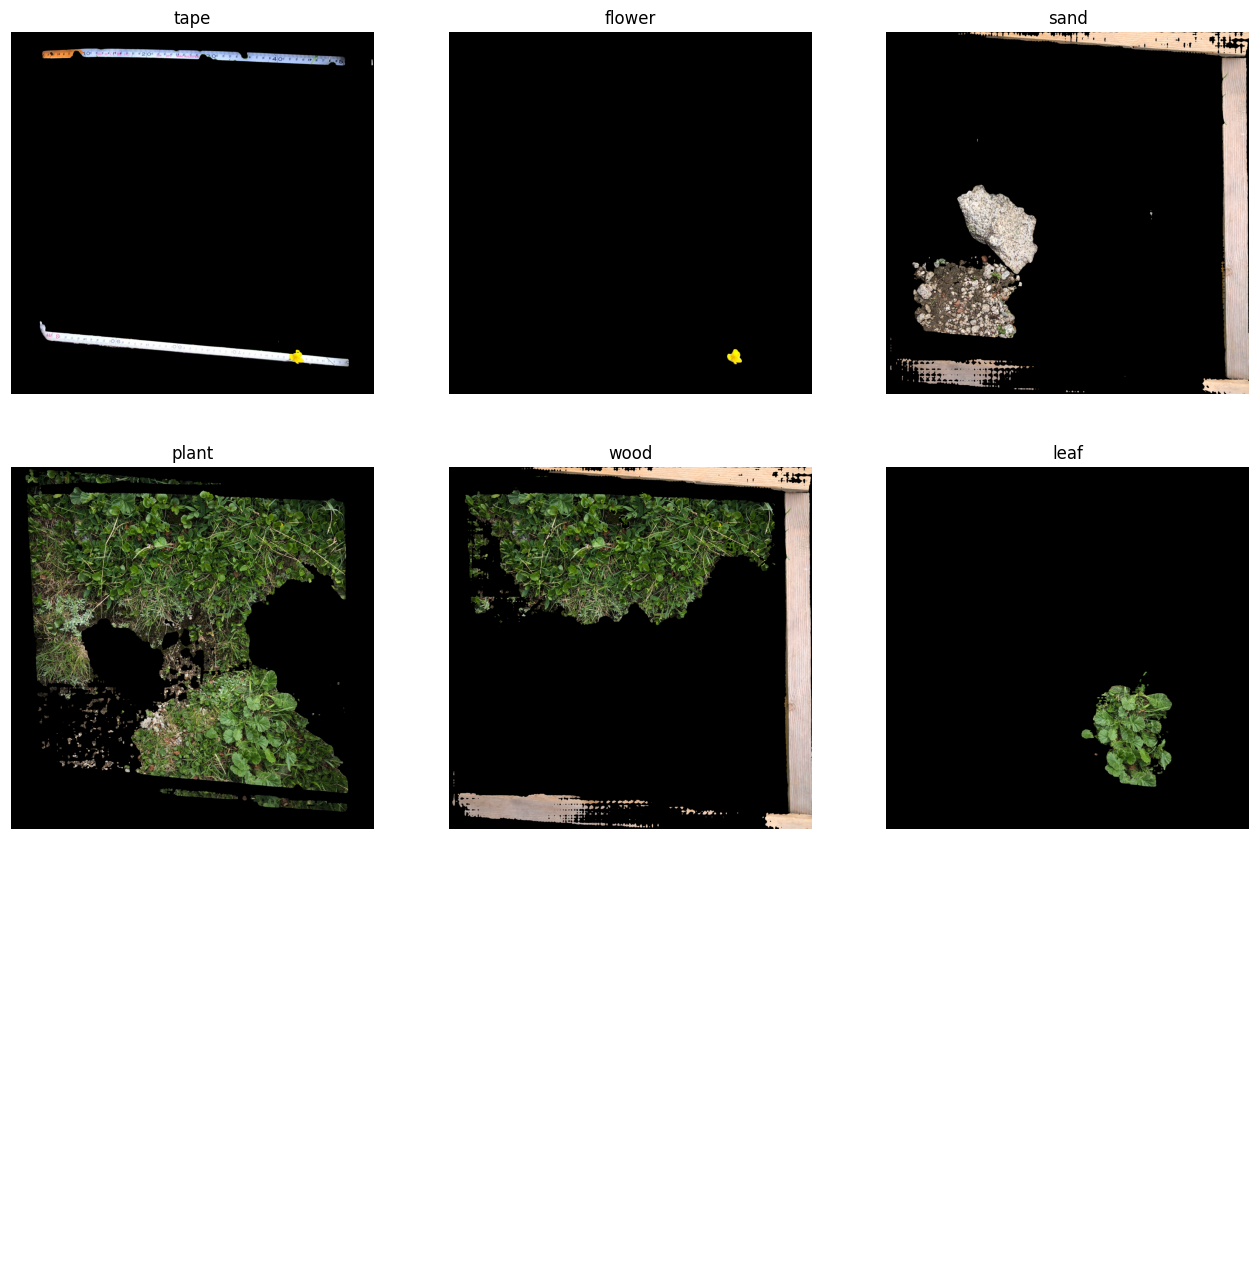

In [29]:
grid_size_dimension = math.ceil(math.sqrt(len(segmented_images)))

sv.plot_images_grid(
    images=segmented_images,
    titles=merged_titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16),
)

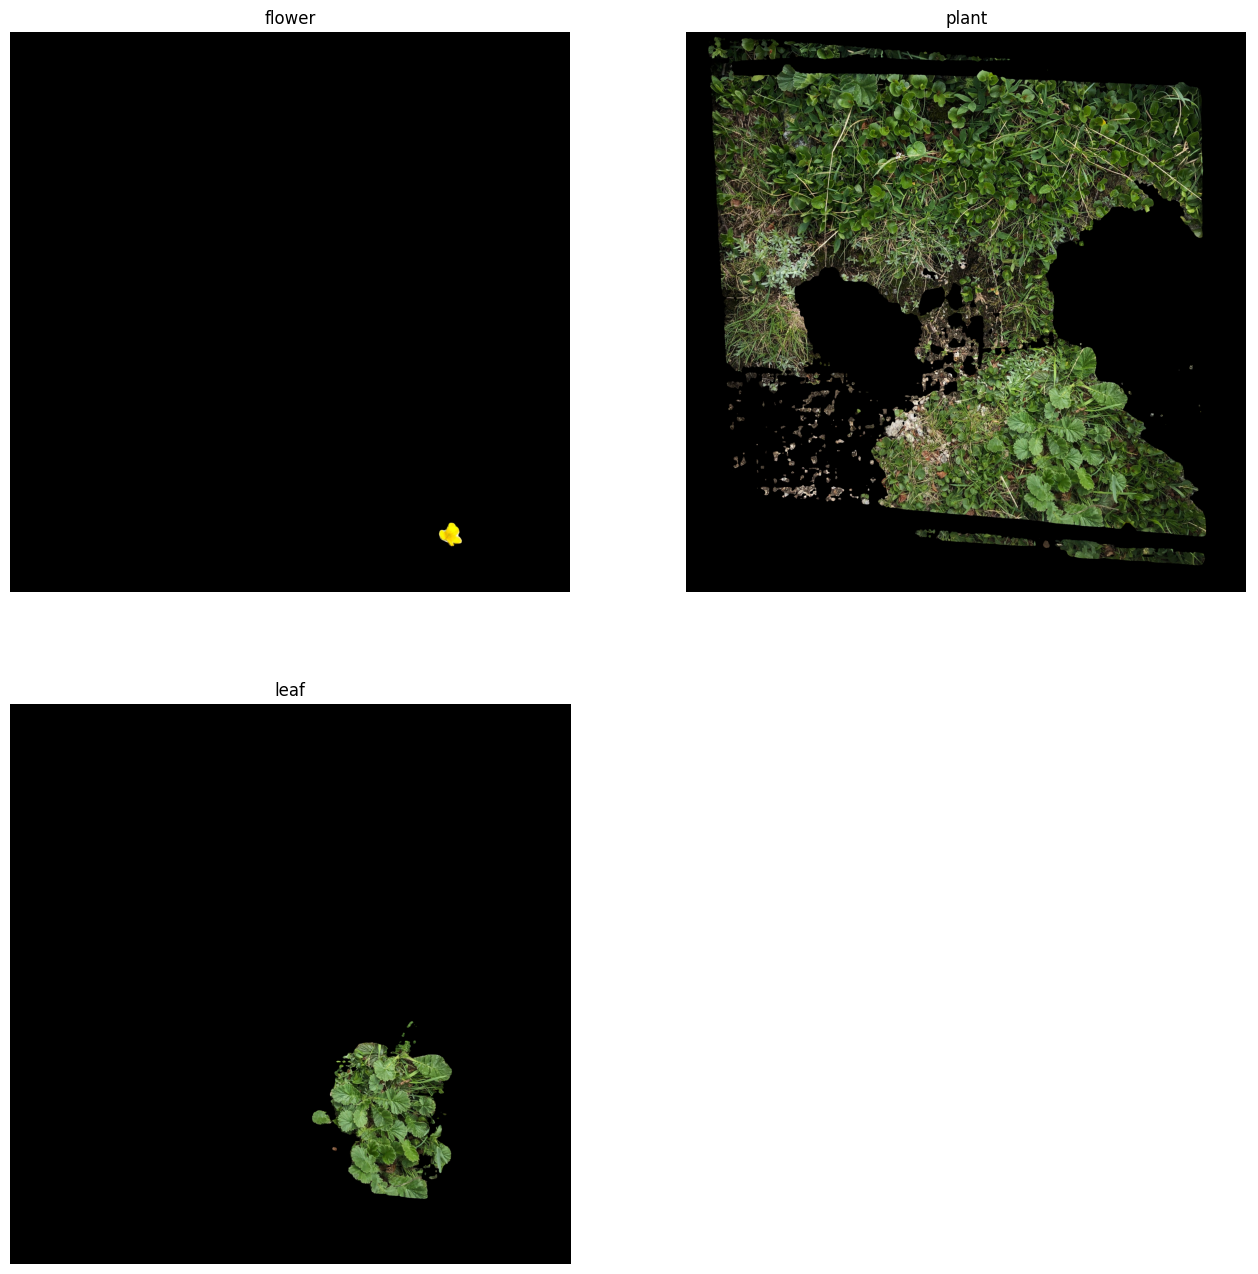

In [30]:
desired_titles = {"leaf", "plant", "flower"}

filtered_images = []
filtered_titles = []
for image, title in zip(segmented_images, merged_titles):
    if title in desired_titles:
        filtered_images.append(image)
        filtered_titles.append(title)


grid_size_dimension = math.ceil(math.sqrt(len(filtered_images)))


sv.plot_images_grid(
    images=filtered_images,
    titles=filtered_titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16),
)

In [32]:
print(merged_masks[0].shape)

(3024, 3024)


In [33]:
print(image.shape)

(3024, 3024, 3)
